In [44]:
# import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import sin,cos,log,pi,linspace,meshgrid,zeros,ones,reshape,abs, copy
from scipy.sparse import spdiags,eye, kron
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Poisson problem

\begin{align*}
    u_{xx} + u_{yy} = f
\end{align*}

The operator $\nabla^2$ defined by 
\begin{align*}
    \nabla^2u = u_{xx} + u_{yy}
\end{align*}
is called the $Laplacian$. 

## The 5-point stencil for the Laplacian
To discuss discretizations, first consider the Poisson problem on the unit square and suppose we have Dirichlet boundary conditions. We will use uniform Cartesian grid consisting of grid points $(x_i, y_j)$, where $x_i = i\Delta x$ and $y_j = j\Delta y$. 
Let $u_{ij}$ represent an approximation to $u(x_i,y_j)$. To discretize we replace the x- and y-derivatives with centered finite differences, which gives

\begin{align*}
    \frac{1}{(\Delta x)^2}\left( u_{i - 1, j} - 2u_{ij} + u_{i + 1, j} \right) + 
    \frac{1}{(\Delta y)^2}\left( u_{i, j - 1} - 2u_{ij} + u_{i, j + 1} \right) = f_{ij}
\end{align*}

For simplicity of notation we will consider the special case where $\Delta x \equiv \Delta y \equiv h$. We can rewrite the above equation as

\begin{align*}
    \frac{1}{h^2}\left( u_{i-1, j} + u_{i+1,j} + u_{i, j - 1} + u_{i,j + 1}- 4u_{ij} \right) = f_{ij}
\end{align*}

In [5]:
def five_point_lap(u_sol, m, h, f):                
    arr_1 = ones(m*m)
    arr_2 = ones(m*m)
    arr_3 = ones(m*m)
    
    for i in range(1, m):
        arr_2[i*m - 1] = 0
        arr_3[i*m] = 0
         
    Coeff_mat = spdiags([-4*arr_1, arr_1, arr_1, arr_2, arr_3],[0, -m, m, -1, 1], m*m,m*m)
    
    x, y = linspace(0,1, m + 2)[1:m+1], linspace(0,1, m + 2)[1:m+1]
    X, Y = meshgrid(x, y)
    
    F = h*h*f(X, Y)
    
    F[ 0,  :] -= u_sol(x, 0)
    F[-1,  :] -= u_sol(x, 1)
    F[ :,  0] -= u_sol(0, y)
    F[ :, -1] -= u_sol(1, y)

    F  = F.reshape(m*m)

    u_approx = spsolve(Coeff_mat, F)
    u_real = u_sol(X, Y)
    return(u_approx, u_real.reshape(m*m))

In [7]:
# def f_1(x,y):
#     return(-np.sin(2.0*np.pi*x) * np.cos(2.0*np.pi*y))

# def u_sol_1(x, y):
#     return((1/(2*(2*np.pi)**2))*np.sin(2*np.pi*x)*np.cos(2*np.pi*y))

def f_1(x, y):
    return(-sin(x) - sin(y))

def u_sol_1(x, y):
    return(sin(x) + sin(y))

num_sol_1, sol_1 = five_point_lap(u_sol_1, 10, 1/11, f_1)
num_sol_2, sol_2 = five_point_lap(u_sol_1, 50, 1/(51), f_1)
num_sol_3, sol_3 = five_point_lap(u_sol_1, 80, 1/(81), f_1)

error_1 = max(abs(num_sol_1 - sol_1))
error_2 = max(abs(num_sol_2 - sol_2))
error_3 = max(abs(num_sol_3 - sol_3))

slope_1 = (log(error_2) - log(error_1))/(log(1/51) - log(1/11))
slope_2 = (log(error_3) - log(error_2))/(log(1/81) - log(1/51))

print('--------------------------------------------------------')
print('Maximum Error')
print('--------------------------------------------------------')
print('m       h          error')
print('10      {:.4f}'.format(1/11), '   ', error_1)
print('50      {:.4f}'.format(1/51), '   ', error_2)
print('80      {:.4f}'.format(1/81), '   ', error_3)

print('--------------------------------------------------------')
print('Error Rate')
print('--------------------------------------------------------')
print('m       h          Error Rate')
print('10      {:.4f}'.format(1/11), '   ')
print('50      {:.4f}'.format(1/51), '   ', slope_1)
print('80      {:.4f}'.format(1/81), '   ', slope_2)


--------------------------------------------------------
Maximum Error
--------------------------------------------------------
m       h          error
10      0.0909     4.8755797680488655e-05
50      0.0196     2.2865650288750317e-06
80      0.0123     9.066783757116781e-07
--------------------------------------------------------
Error Rate
--------------------------------------------------------
m       h          Error Rate
10      0.0909    
50      0.0196     1.9947277223403896
80      0.0123     1.9995053304433341


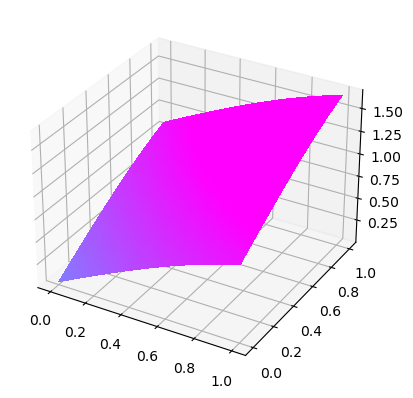

In [35]:
# %matplotlib notebook
m_1 = 80
        
x = linspace(0, 1, m_1)
y = linspace(0, 1, m_1)

X, Y = meshgrid(x,y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, num_sol_3.reshape((m_1, m_1)), cmap='cool', linewidth=0, antialiased=False, vmin=-1, vmax=1)
# ax.plot_surface(X, Y, sol_3.reshape((m_1, m_1)), cmap='viridis', linewidth=0, antialiased=False, vmin=-1, vmax=1)

# fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_zlim(-1.01, 1.01)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label');

In [100]:
def nine_point_lap(u_sol, m, h, f, grad_f):                
    arr_1 = ones(m*m)
    arr_2 = ones(m*m)
    arr_3 = ones(m*m)
    
    for i in range(1, m):
        arr_2[i*m - 1] = 0
        arr_3[i*m] = 0
         
    arr_4 = copy(arr_3)
    arr_4[0] = 0
    
    arr_5 = copy(arr_2)
    arr_5[-1] = 0
    
    Coeff_mat = spdiags([-20*arr_1, 4*arr_1, 4*arr_1, 4*arr_2, 4*arr_3, arr_2, arr_4, arr_5, arr_3],
                        [0, -m, m, -1, 1, -m -1, -m+1, m - 1, m+1], 
                        m*m,m*m)
    
    
    print(Coeff_mat.toarray())
    
    x, y = linspace(0,1, m + 2), linspace(0,1, m + 2)
    X, Y = meshgrid(x[1:m+1], y[1:m+1])
    
    F = 6*h*h*(f(X, Y) + h*h* grad_f(X, Y)/12)
    
#     print(F)
    
    F[ 0,  :] -= u_sol(x[0: m], 0) + 4*u_sol(x[1: m + 1], 0) + u_sol(x[2: m + 2], 0)
    print(F)
    F[-1,  :] -= u_sol(x[0: m], 1) + 4*u_sol(x[1: m + 1], 1) + u_sol(x[2: m + 2], 1)
    print(F)
    F[ :,  0] -= u_sol(0, y[0: m]) + 4*u_sol(0, y[1: m + 1]) + u_sol(0, y[2: m + 2])
    print(F)
    F[ :, -1] -= u_sol(1, y[0: m]) + 4*u_sol(1, y[1: m + 1]) + u_sol(1, y[2: m + 2])
    print(F)

    F[0, 0]  += u_sol(0, 0)
    F[0, -1] += u_sol(1, 0)
    F[-1, 0] += u_sol(0, 1)
    F[-1, -1]+= u_sol(1, 1)
    

    print(F)

    F  = F.reshape(m*m)
    

    u_approx = spsolve(Coeff_mat, F)
    u_real = u_sol(X, Y)
    return(u_approx, u_real.reshape(m*m))


In [104]:
def f_1(x,y):
    return(-sin(2.0*pi*x) * cos(2.0*pi*y))

def u_sol_1(x, y):
    return((1/(2*(2*pi)**2))*sin(2*pi*x)*cos(2*pi*y))

def grad_f_1(x, y):
    return(2*(2*pi)**2*sin(2.0*pi*x) * cos(2.0*pi*y))

# def f_1(x, y):
#     return(-sin(x) - sin(y))

# def u_sol_1(x, y):
#     return(sin(x) + sin(y))

# def grad_f_1(x, y):
#     return(sin(x) + sin(y))

num_sol_1, sol_1 = nine_point_lap(u_sol_1, 10, 1/11, f_1, grad_f_1)
num_sol_2, sol_2 = nine_point_lap(u_sol_1, 50, 1/(51), f_1, grad_f_1)
num_sol_3, sol_3 = nine_point_lap(u_sol_1, 80, 1/(81), f_1, grad_f_1)

error_1 = max(abs(num_sol_1 - sol_1))
error_2 = max(abs(num_sol_2 - sol_2))
error_3 = max(abs(num_sol_3 - sol_3))

slope_1 = (log(error_2) - log(error_1))/(log(1/51) - log(1/11))
slope_2 = (log(error_3) - log(error_2))/(log(1/81) - log(1/51))

print('--------------------------------------------------------')
print('Maximum Error')
print('--------------------------------------------------------')
print('m       h          error')
print('10      {:.4f}'.format(1/11), '   ', error_1)
print('50      {:.4f}'.format(1/51), '   ', error_2)
print('80      {:.4f}'.format(1/81), '   ', error_3)

print('--------------------------------------------------------')
print('Error Rate')
print('--------------------------------------------------------')
print('m       h          Error Rate')
print('10      {:.4f}'.format(1/11), '   ')
print('50      {:.4f}'.format(1/51), '   ', slope_1)
print('80      {:.4f}'.format(1/81), '   ', slope_2)



[[-20.   4.   0. ...   0.   0.   0.]
 [  4. -20.   4. ...   0.   0.   0.]
 [  0.   4. -20. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -20.   4.   0.]
 [  0.   0.   0. ...   4. -20.   4.]
 [  0.   0.   0. ...   0.   4. -20.]]
[[-0.04246422 -0.07144635 -0.07774477 -0.05935977 -0.02212847  0.02212847
   0.05935977  0.07774477  0.07144635  0.04246422]
 [-0.00175519 -0.00295311 -0.00321345 -0.00245354 -0.00091464  0.00091464
   0.00245354  0.00321345  0.00295311  0.00175519]
 [ 0.0006013   0.00101169  0.00110088  0.00084054  0.00031334 -0.00031334
  -0.00084054 -0.00110088 -0.00101169 -0.0006013 ]
 [ 0.00276688  0.00465529  0.00506568  0.00386776  0.00144184 -0.00144184
  -0.00386776 -0.00506568 -0.00465529 -0.00276688]
 [ 0.00405399  0.00682087  0.00742217  0.00566698  0.00211257 -0.00211257
  -0.00566698 -0.00742217 -0.00682087 -0.00405399]
 [ 0.00405399  0.00682087  0.00742217  0.00566698  0.00211257 -0.00211257
  -0.00566698 -0.00742217 -0.00682087 -0.00405399]
 [ 0.00276688  0.00465

In [102]:
nine_point_lap(u_sol_1, 3, 1/4, f_1, grad_f_1)

[[-20.   4.   0.   4.   1.   0.   0.   0.   0.]
 [  4. -20.   4.   1.   4.   1.   0.   0.   0.]
 [  0.   4. -20.   0.   1.   4.   0.   0.   0.]
 [  4.   1.   0. -20.   4.   0.   4.   1.   0.]
 [  1.   4.   1.   4. -20.   4.   1.   4.   1.]
 [  0.   1.   4.   0.   4. -20.   0.   1.   4.]
 [  0.   0.   0.   4.   1.   0. -20.   4.   0.]
 [  0.   0.   0.   1.   4.   1.   4. -20.   4.]
 [  0.   0.   0.   0.   1.   4.   0.   4. -20.]]
[[-1.4998058  -2.89193512 -4.10521431]
 [-0.04519025 -0.05961607 -0.07218857]
 [-0.05776275 -0.07218857 -0.08476107]]
[[-1.4998058  -2.89193512 -4.10521431]
 [-0.04519025 -0.05961607 -0.07218857]
 [-6.57563003 -7.96775935 -9.18103854]]
[[ -2.96884718  -2.89193512  -4.10521431]
 [ -2.89193512  -0.05961607  -0.07218857]
 [-10.6230816   -7.96775935  -9.18103854]]
[[ -2.96884718  -2.89193512 -10.6230816 ]
 [ -2.89193512  -0.05961607  -7.96775935]
 [-10.6230816   -7.96775935 -18.27731601]]
[[ -2.96884718  -2.89193512  -9.78161061]
 [ -2.89193512  -0.05961607  -7.967

(array([0.46835174, 0.68714372, 0.89378262, 0.68714372, 0.90103773,
        1.11110729, 0.89378262, 1.11110729, 1.3192135 ]),
 array([0.49480792, 0.7268295 , 0.92904272, 0.7268295 , 0.95885108,
        1.1610643 , 0.92904272, 1.1610643 , 1.36327752]))